In [1]:
%pip install text_hammer

  Obtaining dependency information for text_hammer from https://files.pythonhosted.org/packages/84/3a/955cead96434a981761e4dbe5ca24241df8595f9459875ea1be7bf6eece7/text_hammer-0.1.5-py3-none-any.whl.metadata
  Obtaining dependency information for beautifulsoup4==4.9.1 from https://files.pythonhosted.org/packages/66/25/ff030e2437265616a1e9b25ccc864e0371a0bc3adb7c5a404fd661c6f4f6/beautifulsoup4-4.9.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.12.2
    Uninstalling beautifulsoup4-4.12.2:
      Successfully uninstalled beautifulsoup4-4.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libpysal 4.9.2 requires beautifulsoup4>=4.10, but you have beautifulsoup4 4.9.1 which is incompatible.
libpysal 4.9.2 requires pack

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from transformers import AutoTokenizer, TFBertModel
import text_hammer as th

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

from sklearn.model_selection import train_test_split

# Load Data

In [3]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

Axes(0.125,0.11;0.698618x0.77)
Axes(0.125,0.11;0.698618x0.77)


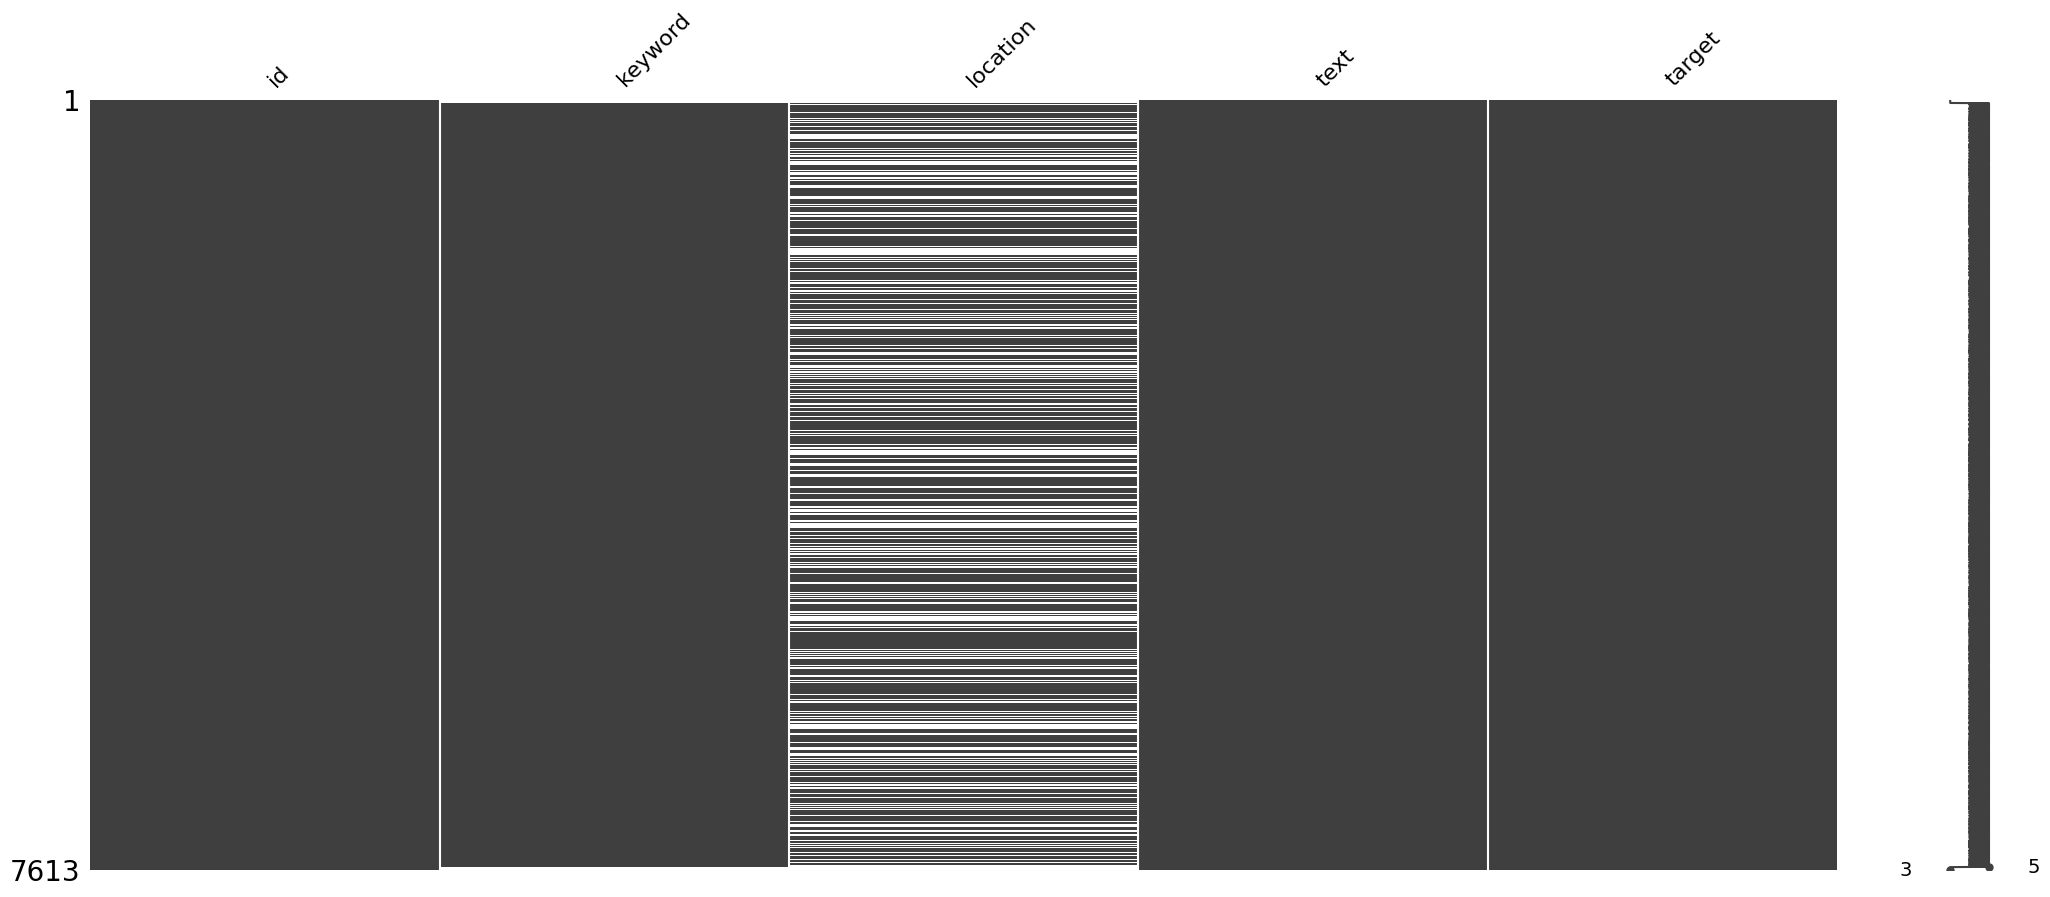

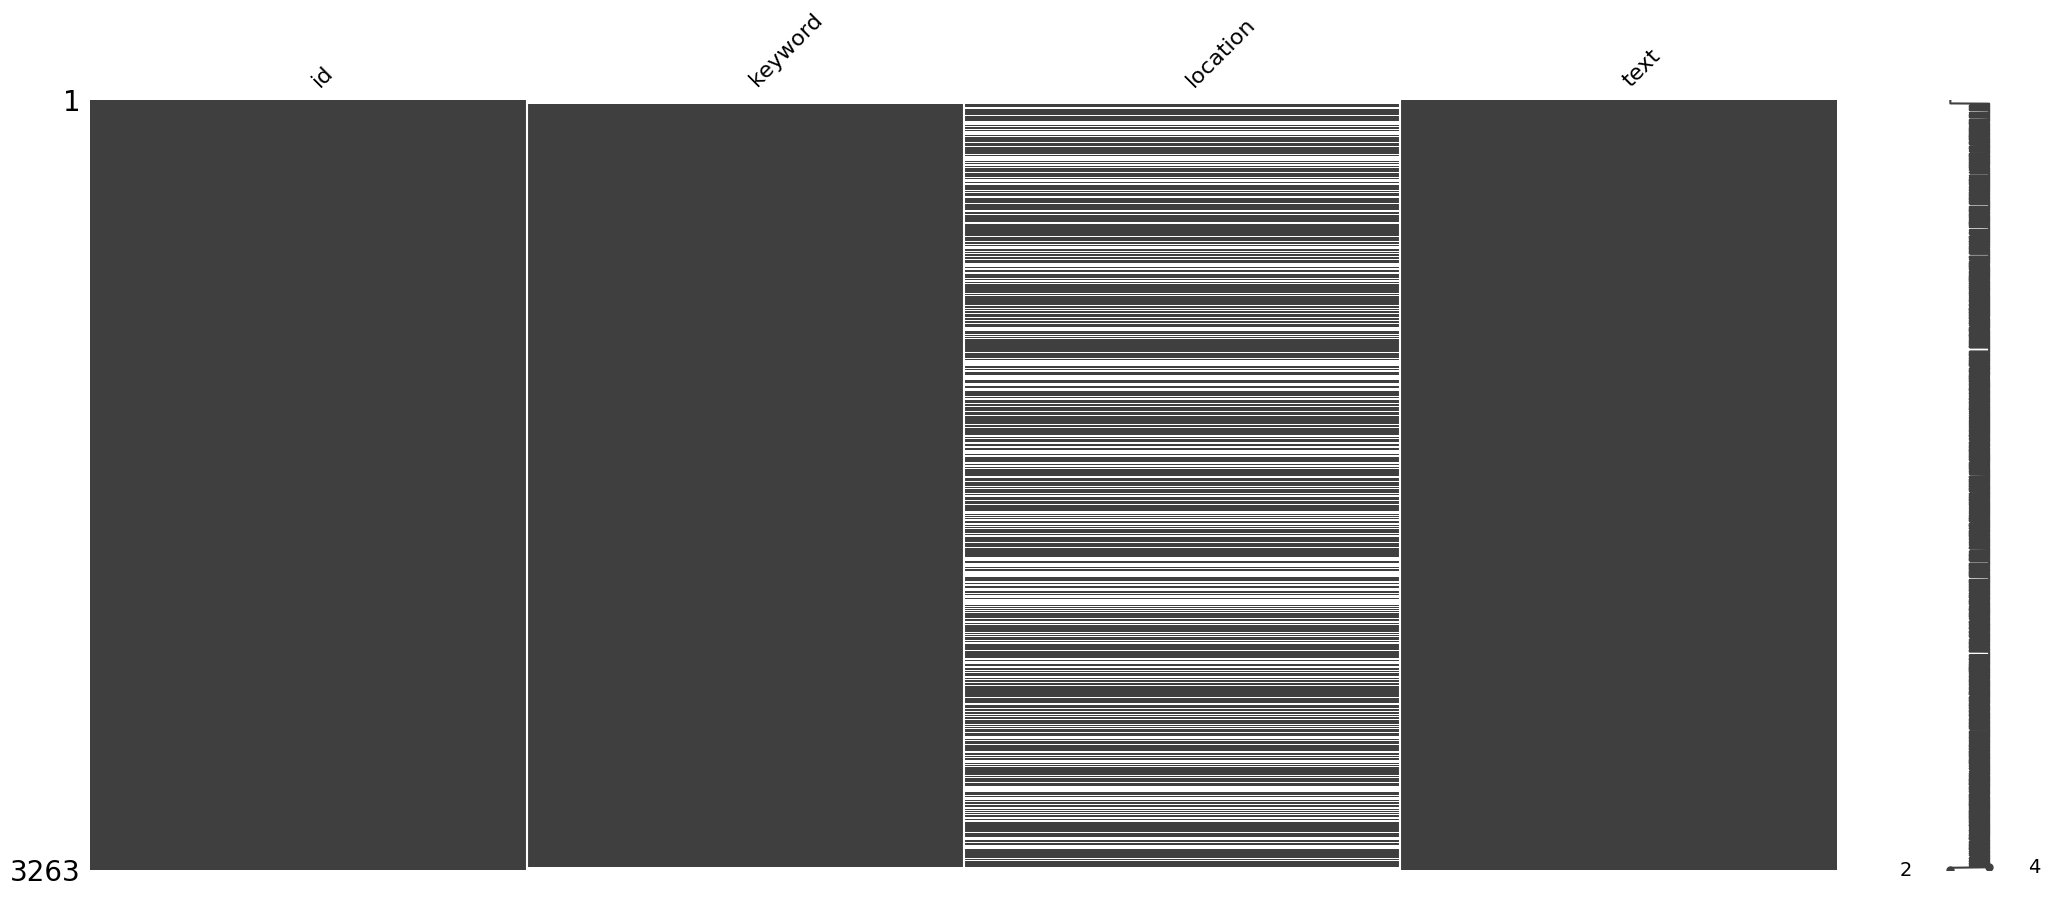

In [4]:
for df in [train,test]:
    print(msno.matrix(df))

Text(0.5, 1.0, 'Target Distributions \n (0: Non Disaster || 1: Disaster)')

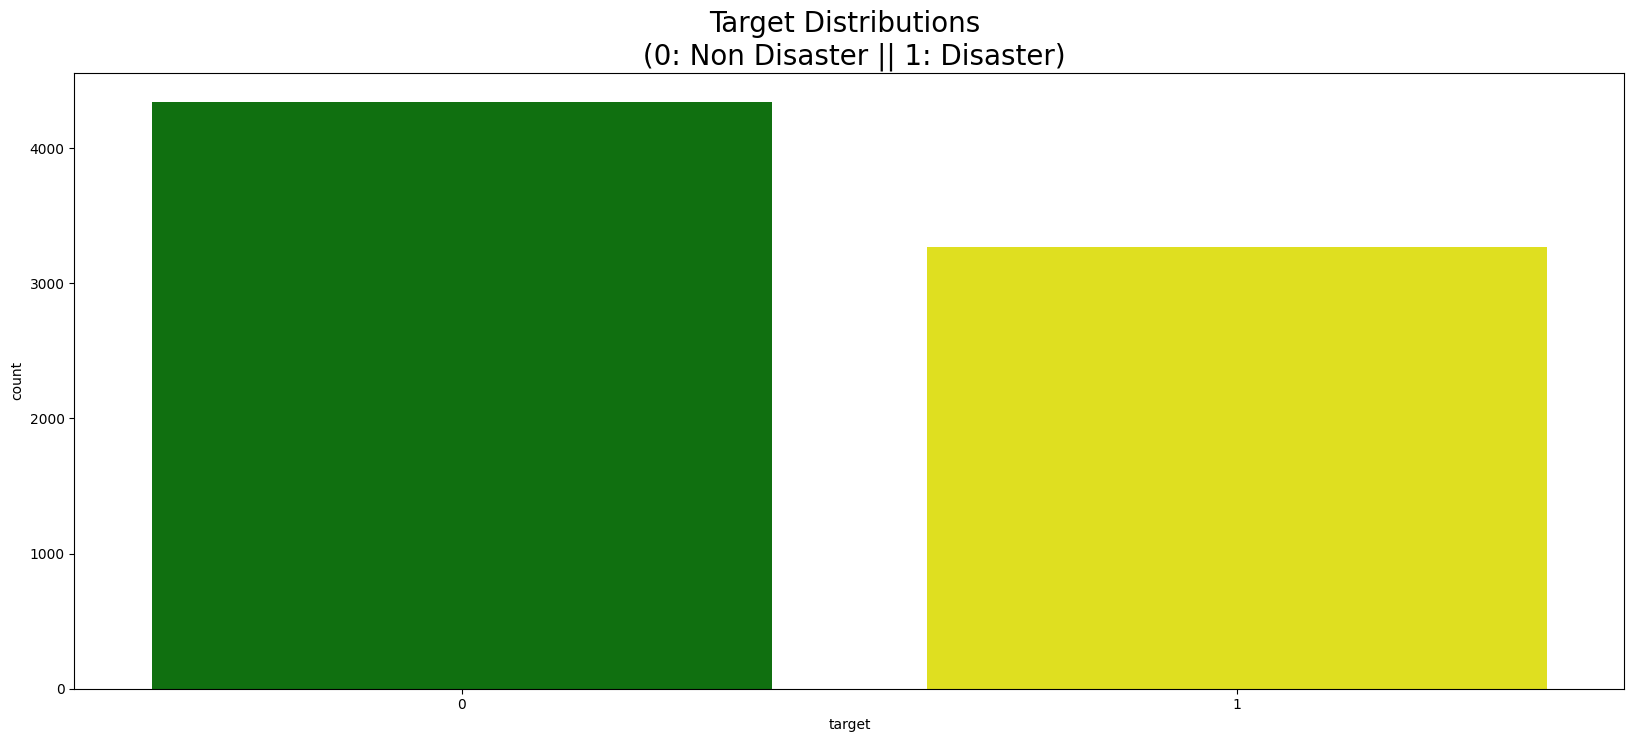

In [5]:
plt.figure(figsize=(20,8))
colors = ["green", "yellow"]

sns.countplot(x = 'target', data=train, palette=colors)
plt.title('Target Distributions \n (0: Non Disaster || 1: Disaster)', fontsize=20)

Text(0.5, 0, 'Count of Keywords')

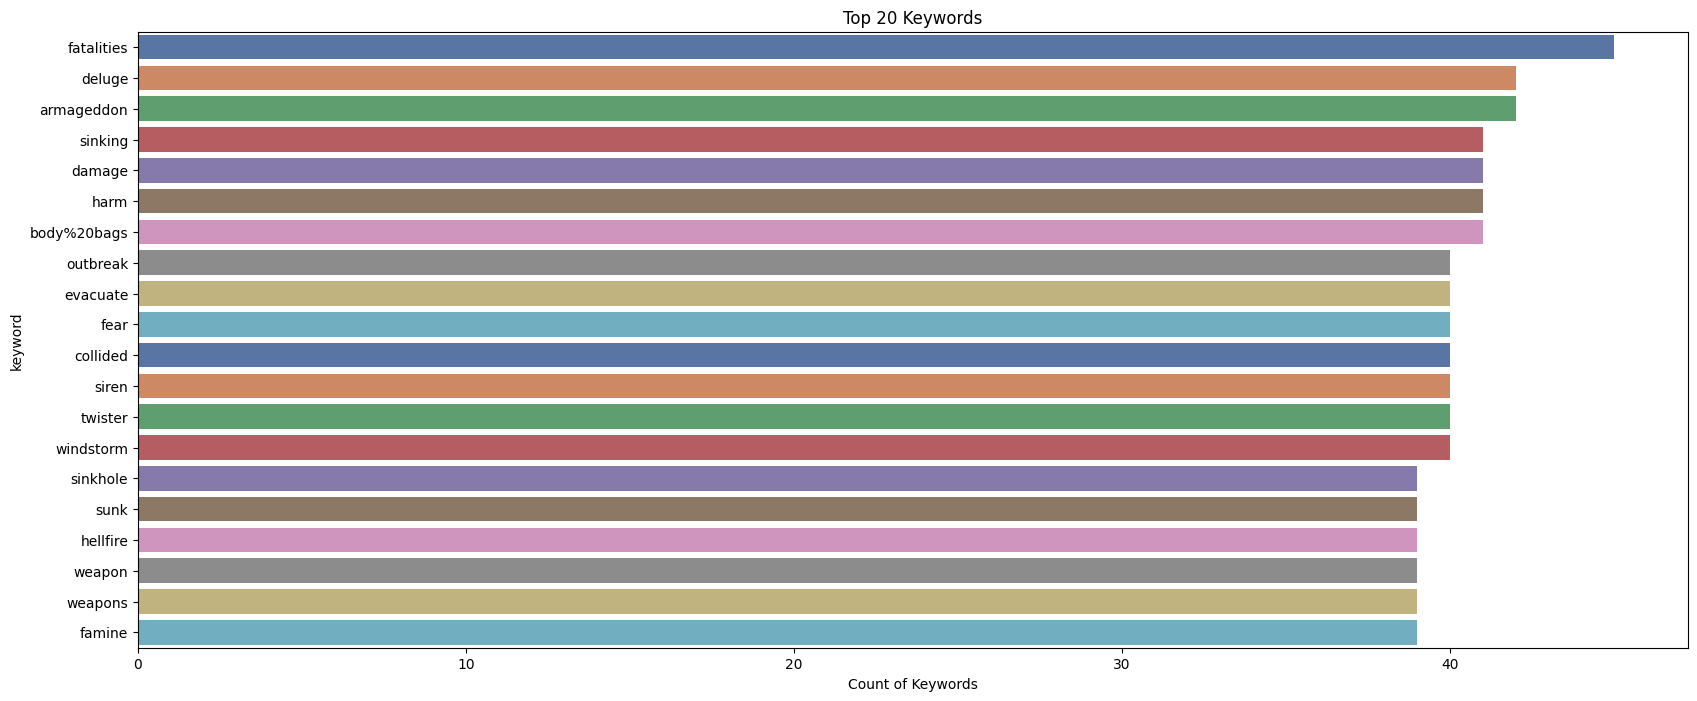

In [6]:
plt.figure(figsize=(20,8))
chains=train['keyword'].value_counts()[:20]
sns.barplot(x=chains,y=chains.index,palette='deep')
plt.title("Top 20 Keywords")
plt.xlabel("Count of Keywords")

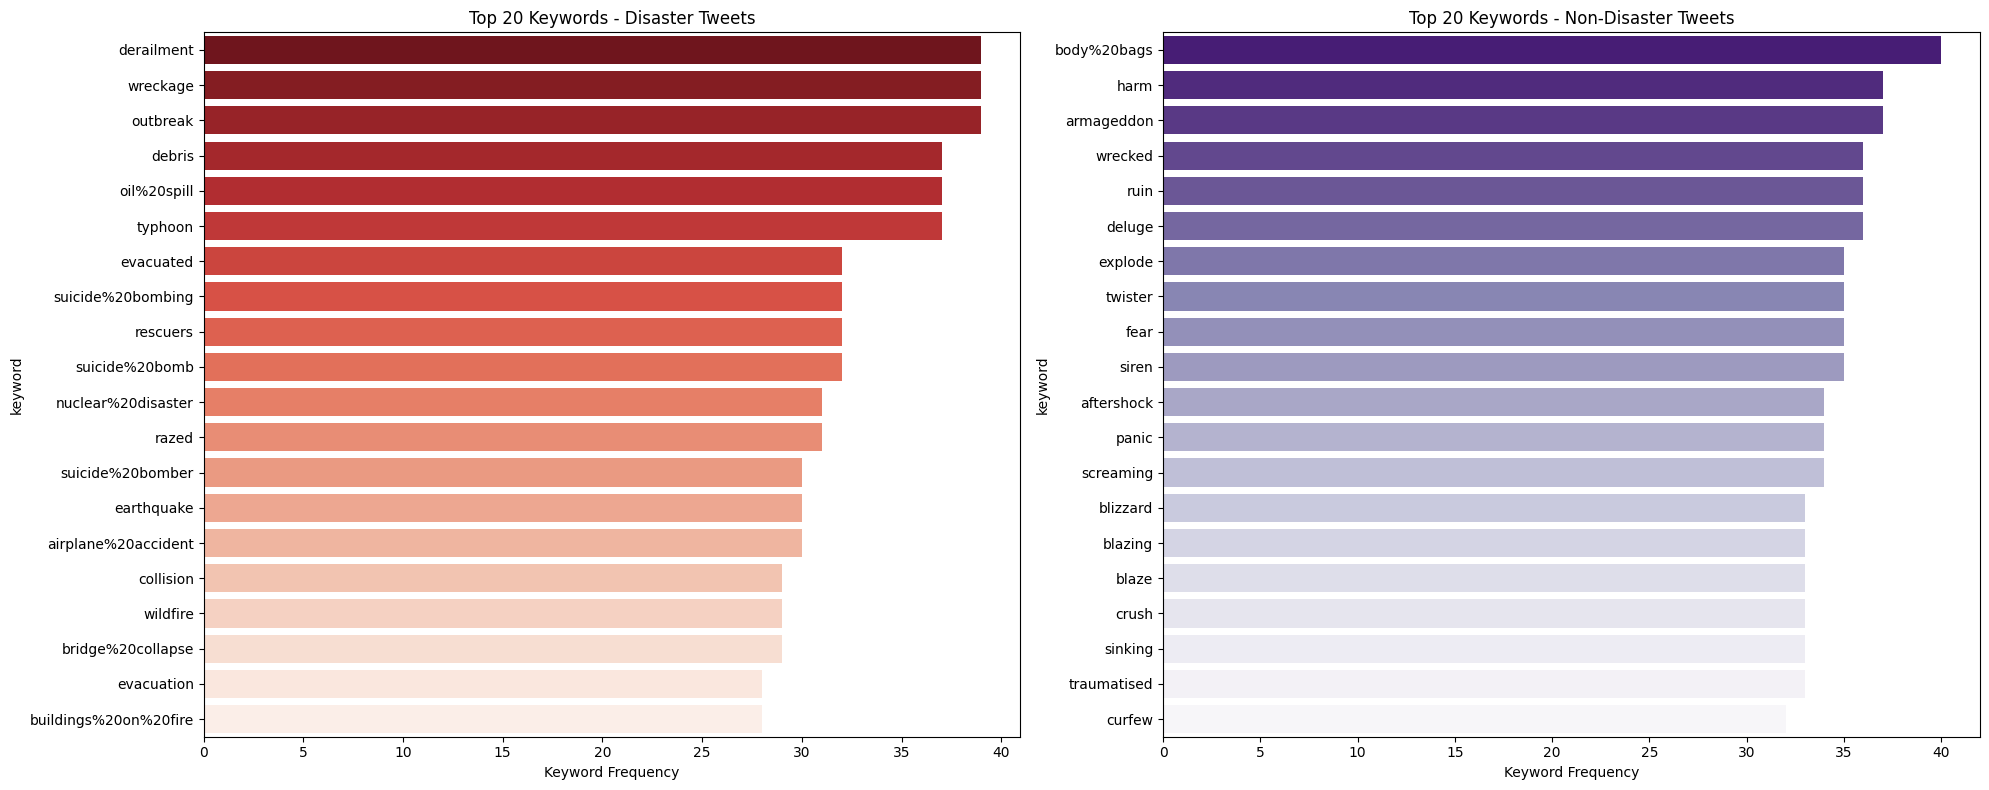

In [7]:
disaster_keywords = train[train["target"] == 1]["keyword"].value_counts().head(20)
nondisaster_keywords = train[train["target"] == 0]["keyword"].value_counts().head(20)

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.barplot(y=disaster_keywords.index, x=disaster_keywords, orient='h', palette="Reds_r")
plt.title("Top 20 Keywords - Disaster Tweets")
plt.xlabel("Keyword Frequency")

plt.subplot(1, 2, 2)
sns.barplot(y=nondisaster_keywords.index, x=nondisaster_keywords, orient='h', palette="Purples_r")
plt.title("Top 20 Keywords - Non-Disaster Tweets")
plt.xlabel("Keyword Frequency")

plt.tight_layout()
plt.show()

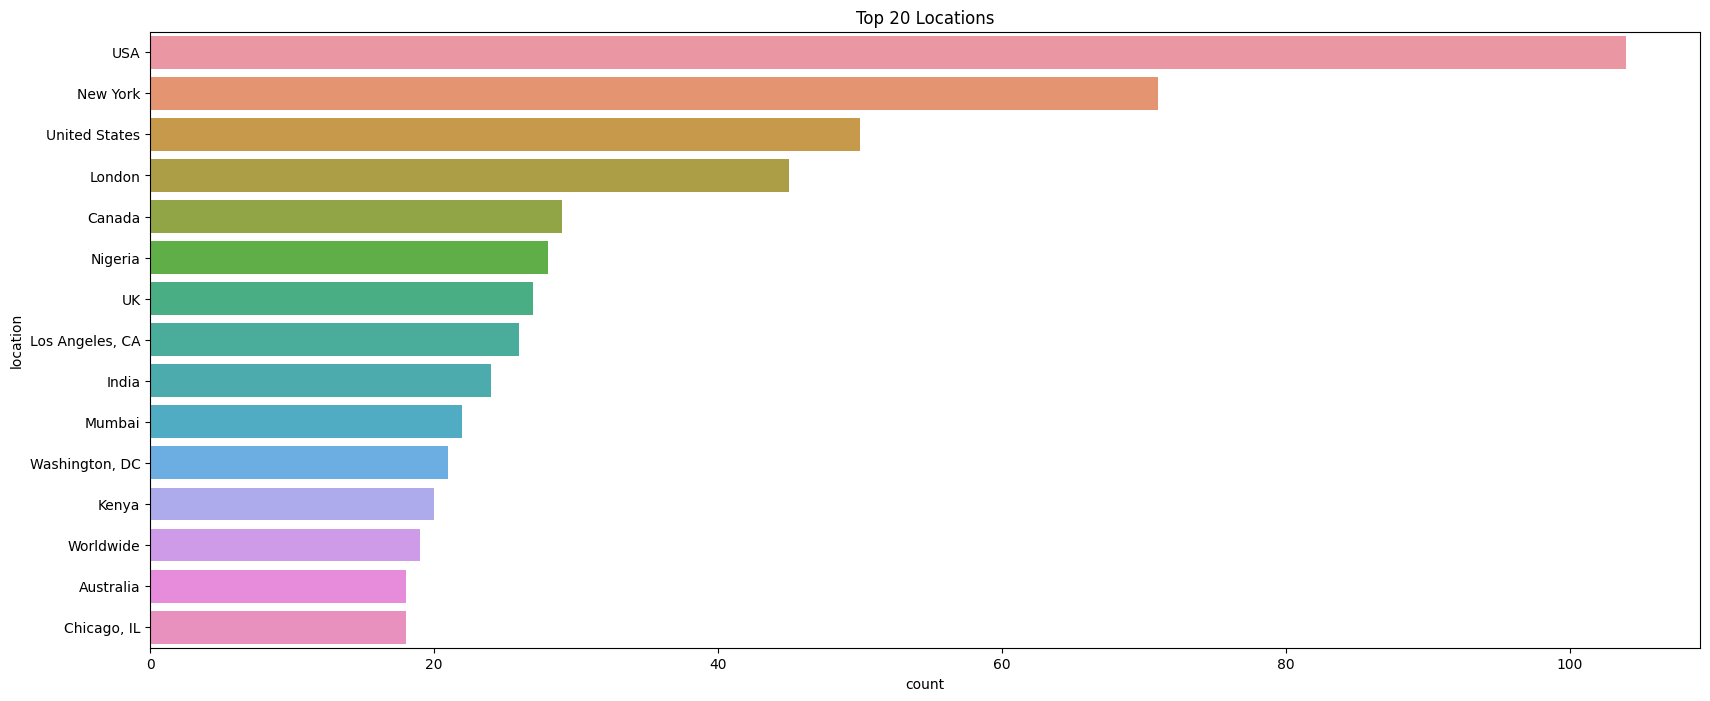

In [8]:
locations = train["location"].value_counts()
plt.figure(figsize=(20,8))
sns.barplot(y=locations[0:15].index, x=locations[0:15], orient='h')

plt.title("Top 20 Locations")
plt.show()

In [9]:
train = train[['id','text','target']]
test = test[['id','text']]

In [10]:
train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
test.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [12]:
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_stopwords(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.make_base(x))
    return df

In [13]:
train_cleaned_df = text_preprocessing(train,'text')

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

In [14]:
train = train_cleaned_df.copy()

In [15]:
train.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

# Load Bert Model

In [16]:
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")
bert = TFBertModel.from_pretrained('bert-large-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

<b>Tokenizer Loading:</b>

The AutoTokenizer ".from_pretrained" function loads a pre-trained tokenizer for BERT from Hugging Face's Transformers library.<br>
This tokenizer is capable of breaking down input text into individual tokens, handling special tokens, and preparing the input in a way that BERT understands.

<b>BERT Model Loading:</b>

The TFBertModel.from_pretrained function loads a pre-trained BERT model from Hugging Face's Transformers library.<br>
'bert-large-uncased' specifies a larger version of the BERT model that is case-insensitive (converts uppercase to lowercase).<br>
This BERT model is a deep neural network that has been pre-trained on a large corpus of text data, and it can be used for various natural language processing tasks.<br>
The loaded BERT model can be further fine-tuned on a specific downstream task or used to extract contextualized embeddings for input text.

In [17]:
tokenizer("Natural Language Processing with Disaster Tweets")

{'input_ids': [101, 3019, 2653, 6364, 2007, 7071, 1056, 28394, 3215, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

<b>token_type_ids:</b>

token_type_ids provides additional information about which sentence each token belongs to. In cases where BERT processes more than one sentence, this helps distinguish between them. <br>
For example, if two sentences are combined and fed as input to the BERT model, token_type_ids is used to specify which sentence each token belongs to. <br>
In this specific example, since it's a single sentence, all token_type_ids values are set to 0.

<b>attention_mask:</b>

The attention mechanism allows the model to focus more on certain parts of the input. attention_mask serves as a mask indicating which positions in the input should be attended to (1) and which positions should be ignored (0).<br>
In this example, all tokens in the sentence are set to be attended to (1), meaning that the model pays equal attention to all parts of the input sentence.

In [18]:
print("Max len of tweets", max([len(x.split()) for x in train.text]))

Max len of tweets 24


In [19]:
x_train = tokenizer(
    text = train.text.tolist(),
    add_special_tokens = True,
    max_length = 24,
    truncation = True,
    padding = True,
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

In [20]:
x_train

{'input_ids': <tf.Tensor: shape=(7613, 24), dtype=int32, numpy=
array([[  101, 15046,  3114, ...,     0,     0,     0],
       [  101,  3224,  2543, ...,     0,     0,     0],
       [  101,  6319,  3198, ...,     0,     0,     0],
       ...,
       [  101, 23290,  2683, ...,  2620, 15878,   102],
       [  101,  2610,  8556, ...,     0,     0,     0],
       [  101,  2397,  2188, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(7613, 24), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [21]:
x_train['input_ids'].shape

TensorShape([7613, 24])

In [22]:
y_train = train.target.values
y_train

array([1, 1, 1, ..., 1, 1, 1])

# Modeling

In [23]:
max_len = 24
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense
input_ids = Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
input_mask = Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')
embeddings = bert([input_ids,input_mask])[1]
out = tf.keras.layers.Dropout(0.1)(embeddings)
out = Dense(128,activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation='relu')(out)
y = Dense(1,activation='sigmoid')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask],outputs=y)
model.layers[2].trainable = True

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 24)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 24)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   3351418   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   88         'attention_mask[0][0]']      
                             hidden_state=(None, 24, 10                                       

In [25]:
optimizer = Adam(
    learning_rate = 5e-06,
    epsilon = 1e-08,
    clipnorm = 1.0
)

loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy')
model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = metric
)

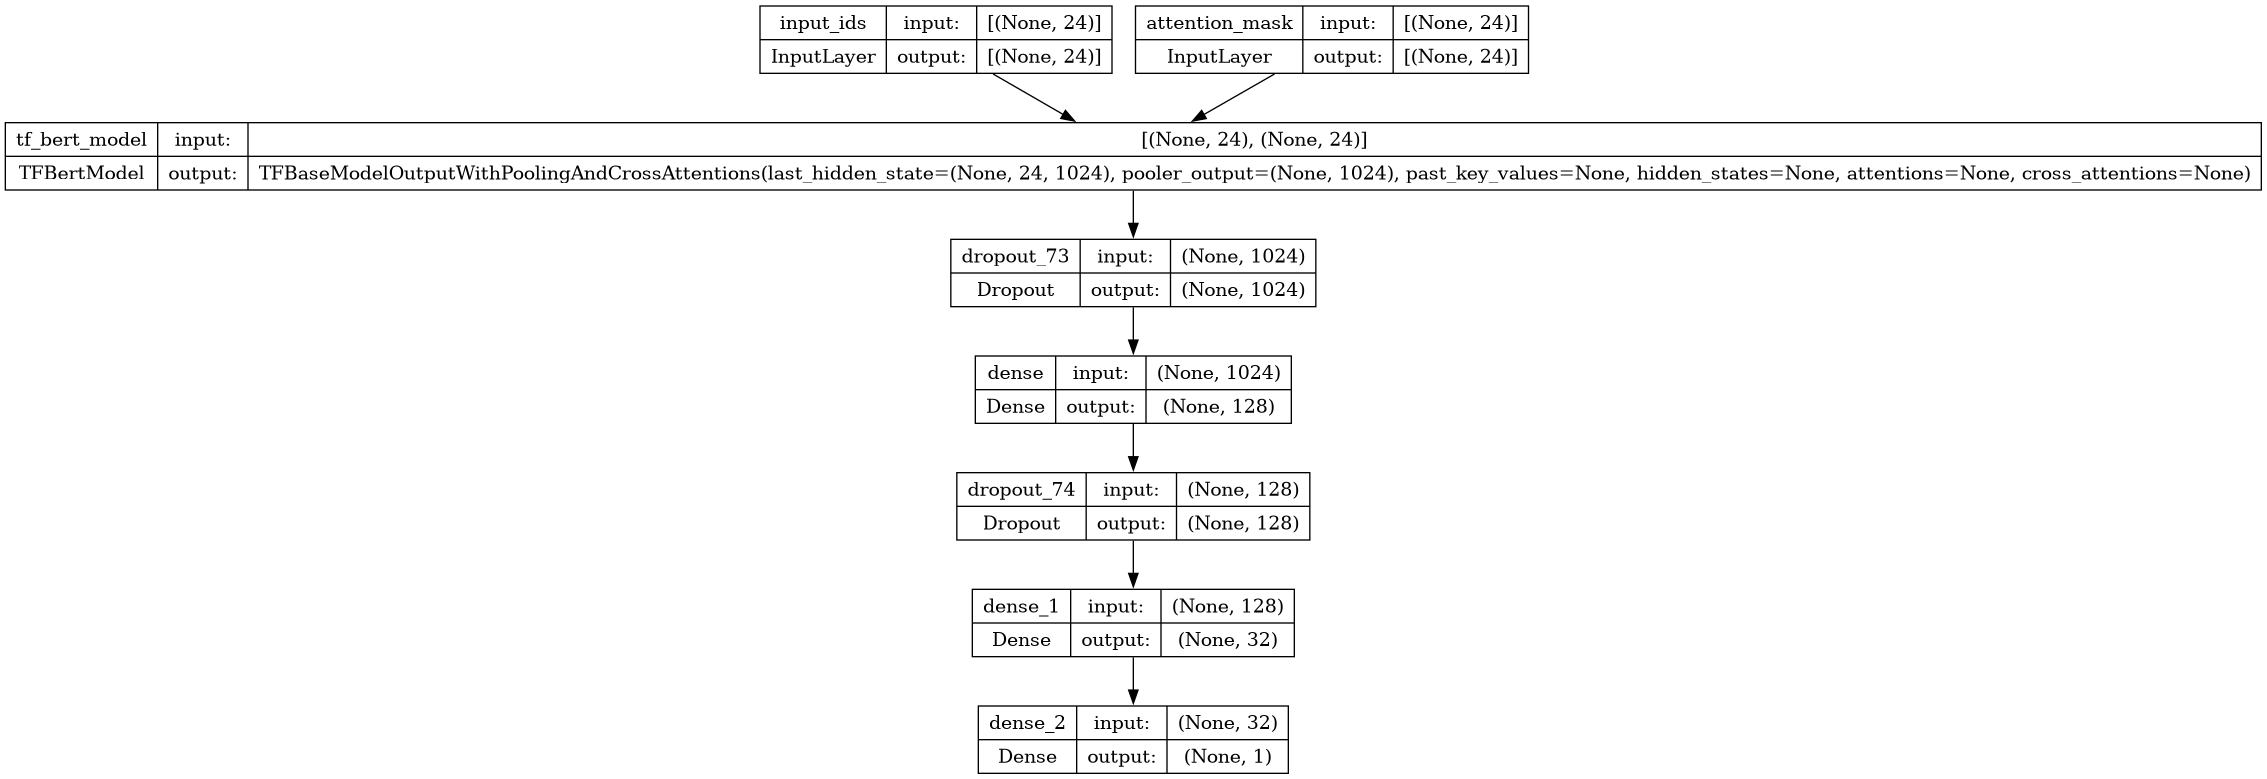

In [26]:
plot_model(model,show_shapes= True)

In [27]:
import tensorflow as tf
tf.config.experimental.list_physical_devices("GPU")

[]

In [28]:
test = text_preprocessing(test,"text")

  0%|          | 0/3263 [00:00<?, ?it/s]

/tmp/ipykernel_20/1686065113.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].progress_apply(lambda x:str(x).lower())


  0%|          | 0/3263 [00:00<?, ?it/s]

/tmp/ipykernel_20/1686065113.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].progress_apply(lambda x: th.cont_exp(x))


  0%|          | 0/3263 [00:00<?, ?it/s]

/tmp/ipykernel_20/1686065113.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].progress_apply(lambda x: th.remove_stopwords(x))


  0%|          | 0/3263 [00:00<?, ?it/s]

/tmp/ipykernel_20/1686065113.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))


  0%|          | 0/3263 [00:00<?, ?it/s]

/tmp/ipykernel_20/1686065113.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))


  0%|          | 0/3263 [00:00<?, ?it/s]

/tmp/ipykernel_20/1686065113.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))


  0%|          | 0/3263 [00:00<?, ?it/s]

/tmp/ipykernel_20/1686065113.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))


  0%|          | 0/3263 [00:00<?, ?it/s]

/tmp/ipykernel_20/1686065113.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].progress_apply(lambda x: th.make_base(x))


In [29]:
test

,id,text
0,0,happen terrible car crash
1,2,hear earthquake different city stay safe everyone
2,3,forest fire spot pond geese flee street save
3,9,apocalypse light spokane wildfire
4,11,typhoon soudelor kill 28 china taiwan
...,...,...
3258,10861,earthquake safety los angeles uo safety fasten...
3259,10865,storm ri bad hurricane city3other hard hit yar...
3260,10868,green line derailment chicago httptcoutbxlcbiuy
3261,10874,meg issue hazardous weather outlook hwo httptc...


In [30]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import tensorflow as tf

k_folds = 5
kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

validation_results = []
test_predictions = []
test_pred_bin = []
validation_predictions = []
train_predictions = []

oof_predictions = np.zeros((len(y_train),))

y_train_np = np.array(y_train)

x_train_ids = tf.constant(x_train['input_ids'])
x_train_masks = tf.constant(x_train['attention_mask'])

x_test = tokenizer(
    text=test.text.tolist(),
    add_special_tokens=True,
    max_length=24,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

for fold, (train_index, val_index) in enumerate(kf.split(x_train_ids, y_train_np)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    x_train_fold_ids = tf.gather(x_train_ids, train_index)
    x_train_fold_masks = tf.gather(x_train_masks, train_index)
    x_val_fold_ids = tf.gather(x_train_ids, val_index)
    x_val_fold_masks = tf.gather(x_train_masks, val_index)
    y_train_fold = y_train_np[train_index]
    y_val_fold = y_train_np[val_index]
    
    model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
    model.layers[2].trainable = True
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[metric]
    )
    
    train_history = model.fit(
        x={"input_ids": x_train_fold_ids, 'attention_mask': x_train_fold_masks},
        y=y_train_fold,
        validation_data=({"input_ids": x_val_fold_ids, 'attention_mask': x_val_fold_masks}, y_val_fold),
        epochs=1,
        batch_size=32
    )
    
    _, accuracy = model.evaluate({"input_ids": x_val_fold_ids, 'attention_mask': x_val_fold_masks}, y_val_fold)
    test_pred = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})
    val_pred = model.predict({'input_ids': x_val_fold_ids, 'attention_mask': x_val_fold_masks})
    train_pred = model.predict({'input_ids': x_train_fold_ids, 'attention_mask': x_train_fold_masks})
    
    oof_predictions[val_index] = np.argmax(val_pred, axis=1)

    validation_results.append(accuracy)
    test_predictions.append(test_pred)
    test_pred_bin.append(np.argmax(test_pred, axis=1))
    validation_predictions.append(np.argmax(val_pred, axis=1))
    train_predictions.append(np.argmax(train_pred, axis=1))

print(f'평균 검증 정확도: {np.mean(validation_results)}')
print('OOF Predictions:', oof_predictions)
print('Binary Test Predictions for each fold:', test_pred_bin)

Fold 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


191/191 [==============================] - 840s 4s/step
Fold 2/5
191/191 [==============================] - 833s 4s/step
Fold 3/5
191/191 [==============================] - 836s 4s/step
Fold 4/5
191/191 [==============================] - 836s 4s/step
Fold 5/5
191/191 [==============================] - 837s 4s/step
평균 검증 정확도: 0.8480285286903382
OOF Predictions: [0. 0. 0. ... 0. 0. 0.]
Binary Test Predictions for each fold: [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
